### **CARTPOLE DDQN Minimal V2 NN training improvements**

This is a naive version vectorized of the DDQN Algorithm for the CARTPOLE env <br>
Vectorizing we obtain a version that is faster and it is 'functional' as it works <br>

The Double DQN (DDQN) uses two networks one as a target and one as the trained network <br>

The target network is a copy of the online network that is updated less frequently, <br>
and is used to generate the target values for the Q-learning update<br>

It includes a soft update of the weights, instead of substituting the weights between the networks<br>
it blends them together using a Polyak averaging This was an improvement on the pure DDQN algorithm<br>

This Version has several neural network training improvements<br>

- Adaptive learning rate <br>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gymnasium as gym
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import set_random_seed
import matplotlib.pyplot as plt
from collections import deque
import random

import time
from PIL import Image

# Activate GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Use mixed-precision training for faster computations on supported GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Enable XLA (Accelerated Linear Algebra) optimization
tf.config.optimizer.set_jit(True)

Num GPUs Available:  1


I0000 00:00:1734890407.649618 2140166 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734890407.668454 2140166 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734890407.668496 2140166 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


#### **Environment setup**

In [2]:
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
               
set_random_seed(221)  # For reproducibility

#### **Hyperparameters**

In [3]:
batch_size = 128
gamma = 0.99                
epsilon_start = 1.0
epsilon_min = 0.01
epsilon_decay = 0.99 

initial_lr = 0.001
d_steps    = 10000
d_rate     = 0.99

buffer_capacity = 10000
retrain_steps = 10            # We copy weights every retrain_steps 
tau = 0.1  

max_episodes = 150
max_steps = 1000
solved_threshold = 195
                  # Soft update, it is high for long retrain periods. Small for short retrain

#lr: 0.0001 gamma 0.99 batch_size 128 tau  0.15 epsilon decay 0.99 retrain_steps  5

#### **Neural Network Definition**

In [4]:
# Build the neural network model
def build_model(state_size, action_size):
    inputs = Input(shape=(state_size,))  
    x = Dense(16, activation="relu")(inputs)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    outputs = Dense(action_size, activation="linear")(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    lr_schedule = ExponentialDecay(
                            initial_learning_rate=initial_lr,
                            decay_steps = d_steps,
                            decay_rate  = d_rate,
                            staircase = True)                                  
    
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss="mse")
    return model

#### **Support Functions**

In [5]:
# Soft update function for target network
""" Soft Update using Polyak optimization """
def soft_update(model, target_model, tau):
    target_weights = target_model.get_weights()
    model_weights = model.get_weights()
    new_weights = [
        tau * mw + (1 - tau) * tw for mw, tw in zip(model_weights, target_weights)
    ]
    target_model.set_weights(new_weights)

#### **Replay Function - The core of the DDQN Algorithm**

In [6]:
# Replay buffer
replay_buffer = deque(maxlen=buffer_capacity)

# Add experience to replay buffer
def store_experience(state, action, reward, next_state, done):
    replay_buffer.append((state, action, reward, next_state, done))

# Sample experiences from the replay buffer
def sample_experiences(batch_size):
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]
    states, actions, rewards, next_states, dones = zip(*batch)
    return (
        np.vstack(states),
        np.array(actions),
        np.array(rewards),
        np.vstack(next_states),
        np.array(dones, dtype=np.float32)
    )

# Double DQN target calculation
def experience_replay_with_ddqn(model, target_model, batch_size, gamma, tau, step):
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)

    # Predict Q-values for next states using both networks
    next_q_values = model.predict(next_states, verbose=0)
    best_actions = np.argmax(next_q_values, axis=1)
    target_q_values = target_model.predict(next_states, verbose=0)

    # Update Q-values using Double DQN formula
    targets = rewards + gamma * target_q_values[np.arange(batch_size), best_actions] * (1 - dones)

    # Update main Q-network
    q_values = model.predict(states, verbose=0)
    q_values[np.arange(batch_size), actions] = targets
    model.fit(states, q_values, epochs=1, verbose=0)

    # Apply soft update to target network
    if step % retrain_steps == 0:   
        soft_update(model, target_model, tau)



#### **Initialize Network models**

In [7]:
model = build_model(state_size, action_size)
target_model = build_model(state_size, action_size)
target_model.set_weights(model.get_weights())             # Sync target network initially

I0000 00:00:1734890407.734854 2140166 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734890407.734919 2140166 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734890407.734937 2140166 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734890408.614971 2140166 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734890408.615024 2140166 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

#### **Training Phase**

In [8]:
# Training loop
epsilon = epsilon_start
episode_rewards = []
rolling_avg_rewards = []

start_time = time.time()

for episode in range(max_episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    done = False
    terminated = False
    truncated = False
    step = 0
    for e in range(max_steps):                       # Should be While True, however we limit number of eps
        step = step + 1
        # Epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.randint(action_size)  # Explore
        else:
            action_vals = model.predict(state, verbose=0)
            action = np.argmax(action_vals[0])  # Exploit

        # Perform action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated 
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward

        # Store experience
        store_experience(state, action, reward, next_state, done)

        # Update state
        state = next_state

        # Train using experience replay
        experience_replay_with_ddqn(model, target_model, batch_size, gamma, tau, step)

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Record reward
    episode_rewards.append(total_reward)
    rolling_avg = np.mean(episode_rewards[-5:])
    rolling_avg_rewards.append(rolling_avg)

    # Print progress
    print(f"Episode: {episode+1:3}/{max_episodes}, Reward: {total_reward:+8.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:6.2f}, Steps: {step:3}, Terminated: {done} ")

    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        model.save("xxx_model1.keras")
        break

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")


Episode:   1/150, Reward:   +50.00, Epsilon: 0.99, Rolling Avg:  50.00, Steps:  50, Terminated: True 
Episode:   2/150, Reward:   +12.00, Epsilon: 0.98, Rolling Avg:  31.00, Steps:  12, Terminated: True 
Episode:   3/150, Reward:   +12.00, Epsilon: 0.97, Rolling Avg:  24.67, Steps:  12, Terminated: True 
Episode:   4/150, Reward:   +23.00, Epsilon: 0.96, Rolling Avg:  24.25, Steps:  23, Terminated: True 
Episode:   5/150, Reward:   +15.00, Epsilon: 0.95, Rolling Avg:  22.40, Steps:  15, Terminated: True 


I0000 00:00:1734890409.388762 2140271 service.cc:146] XLA service 0x7fa0ac004670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734890409.388794 2140271 service.cc:154]   StreamExecutor device (0): NVIDIA T600 Laptop GPU, Compute Capability 7.5
I0000 00:00:1734890410.361369 2140271 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode:   6/150, Reward:   +14.00, Epsilon: 0.94, Rolling Avg:  15.20, Steps:  14, Terminated: True 
Episode:   7/150, Reward:   +20.00, Epsilon: 0.93, Rolling Avg:  16.80, Steps:  20, Terminated: True 
Episode:   8/150, Reward:   +15.00, Epsilon: 0.92, Rolling Avg:  17.40, Steps:  15, Terminated: True 
Episode:   9/150, Reward:   +16.00, Epsilon: 0.91, Rolling Avg:  16.00, Steps:  16, Terminated: True 
Episode:  10/150, Reward:   +14.00, Epsilon: 0.90, Rolling Avg:  15.80, Steps:  14, Terminated: True 
Episode:  11/150, Reward:   +22.00, Epsilon: 0.90, Rolling Avg:  17.40, Steps:  22, Terminated: True 
Episode:  12/150, Reward:   +67.00, Epsilon: 0.89, Rolling Avg:  26.80, Steps:  67, Terminated: True 
Episode:  13/150, Reward:   +31.00, Epsilon: 0.88, Rolling Avg:  30.00, Steps:  31, Terminated: True 
Episode:  14/150, Reward:   +60.00, Epsilon: 0.87, Rolling Avg:  38.80, Steps:  60, Terminated: True 
Episode:  15/150, Reward:   +12.00, Epsilon: 0.86, Rolling Avg:  38.40, Steps:  12

#### **Result Visualization**

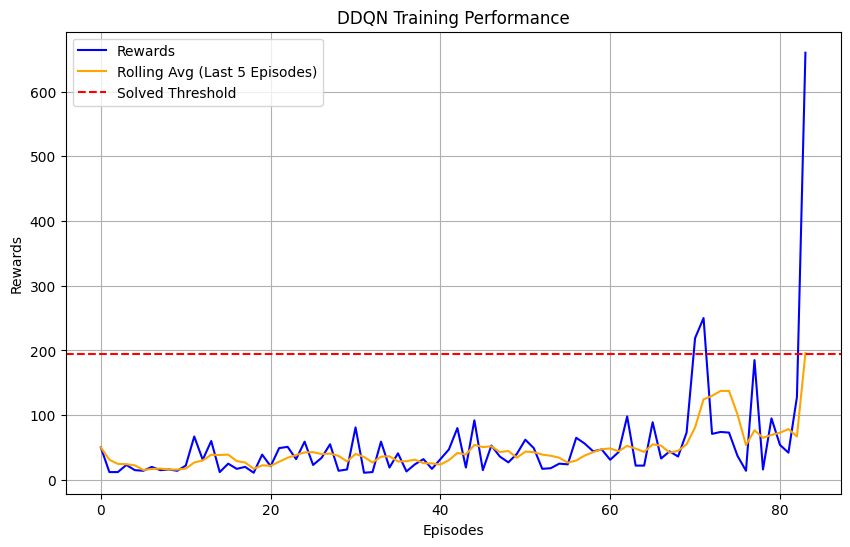

In [9]:
# Plot rewards with rolling average
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 5 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DDQN Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Testing 10 episodes with the DDQN trained networks**

In [12]:
# Testing for 10 episodes
start_time = time.time()
max_steps = 500

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    for s in range(max_steps):                            # we limit because sometimes it goes ad-aeternum
        # Use the trained model for testing
        action_vals = model.predict(state, verbose=0)  # Predict action values
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1

        if done or (steps == max_steps):
            print(f"Test Episode: {e_test + 1}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode: 1/10, Reward: 500.00, Steps: 500
Test Episode: 2/10, Reward: 500.00, Steps: 500
Test Episode: 3/10, Reward: 500.00, Steps: 500
Test Episode: 4/10, Reward: 500.00, Steps: 500
Test Episode: 5/10, Reward: 500.00, Steps: 500
Test Episode: 6/10, Reward: 500.00, Steps: 500
Test Episode: 7/10, Reward: 500.00, Steps: 500
Test Episode: 8/10, Reward: 500.00, Steps: 500
Test Episode: 9/10, Reward: 500.00, Steps: 500
Test Episode: 10/10, Reward: 500.00, Steps: 500
Testing completed in 4.70 minutes


In [11]:
import session_info
session_info.show(html=False)

-----
PIL                 11.0.0
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2024-12-22 19:23
